# Crecimiento monetario

Este notebook tiene los siguientes objetivos:
- Mostrar las diferencias en el crecimiento de la cantidad de dinero en diferentes economías.
- Establecer una relación entre crecimiento de la cantidad de dinero, la velocidad del dinero y la inflación


## Diferencias en cantidad de dinero

Se estudiarán las siguientes áreas monetarias: los Estados Unidos, la Unión Europea, Suiza, el Reino Unido y Japón.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from utils import get_snb_data, get_ecb_data
import pandas as pd

plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'dejavuserif'

In [39]:
df = pd.DataFrame()
df['US'] = pd.read_csv('data/m3-us.csv', sep=';', parse_dates=['Date'], index_col='Date')

df['CH'] = get_snb_data("snbmonagg", {'dimSel': 'D0(B),D1(GM3)',
                                      'fromDate': '1980-01',
                                      })['Value']
df['EU'] = get_ecb_data('BSI',
                        'M.U2.N.V.M30.X.1.U2.2300.Z01.E', date_format='%Y-Q%q'
                        )
df['JP'] = pd.read_csv('data/m3-jp.csv', skiprows=3,
                       names=['Date', 'Value'], parse_dates=['Date'], date_format={'Date': '%Y/%m'}, index_col='Date')


/var/folders/q8/gp6z9yks6ynf_34chydw0yrr0000gn/T/ipykernel_61771/1057431910.py:3: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df.pct_change(periods=12).plot(ax=ax, label='a')


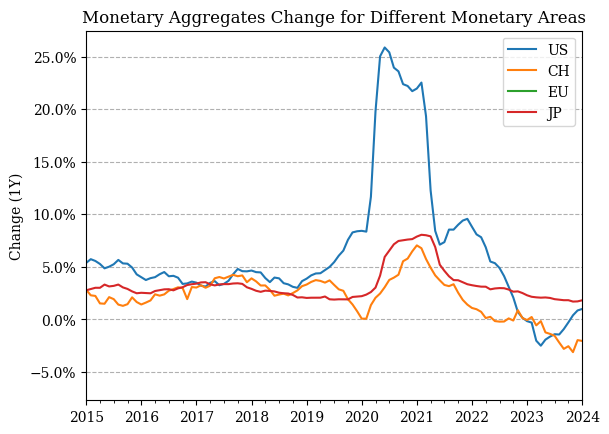

In [3]:
fig, ax = plt.subplots()

df.pct_change(periods=12).plot(ax=ax, label='a')
# plot_recessions(ax)

ax.set_xlim(['2015', '2024'])
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.grid(which='major', axis='y', linestyle='--')  #  or bothdd
ax.set_xlabel('')
ax.set_ylabel('Change (1Y)')
ax.set_title('Monetary Aggregates Change for Different Monetary Areas');

## Estados Unidos

Datos:
- PIB: Gross Domestic Product, Quarterly, Billions of Dollars [GDP](https://fred.stlouisfed.org/series/GDP)
- M3: [ShadowStats](http://www.shadowstats.com)

In [4]:
from fredapi import Fred
from dotenv import load_dotenv
import os

load_dotenv()

fred = Fred(api_key=os.environ.get('FRED_API_KEY'))

In [10]:
# Monthly data
df_us = pd.read_csv('data/m3-us.csv', sep=';', parse_dates=['Date'], index_col='Date')
df_us['gdp'] = fred.get_series('GDP') # Quarterly data

df_us.dropna(inplace=True) # Remove NaN
df_us['v'] = df_us['gdp']/df_us['m3']

Text(0, 0.5, 'Change (1Y)')

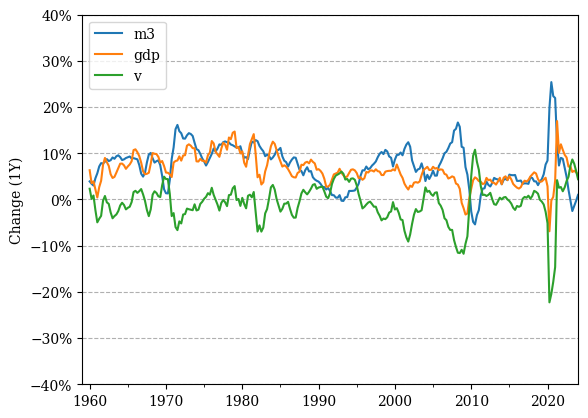

In [11]:
import numpy as np

fig, ax = plt.subplots()

df_us[['m3', 'gdp', 'v']].pct_change(periods=4).plot(ax=ax, label='a')
# ax.set_xlim(['2015', '2024'])
ax.set_ylim([-.4,.4])

ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.grid(which='major', axis='y', linestyle='--')  #  or bothdd
ax.set_xlabel('')
ax.set_ylabel('Change (1Y)')

## Recesiones

Datos obtenidoss de NBER: [US Business Cycle Expansions and Contractions](https://www.nber.org/research/data/us-business-cycle-expansions-and-contractions).

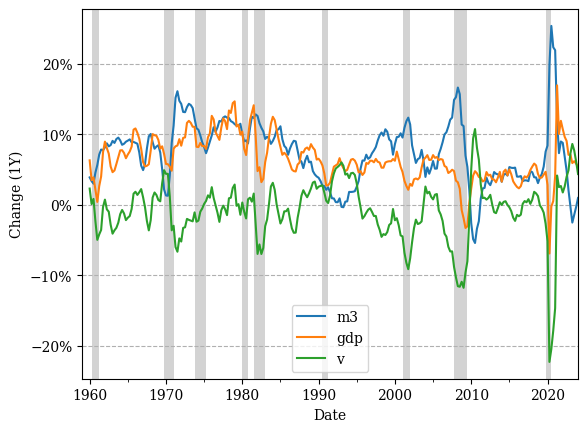

In [12]:
df_us['recession'] = 0
df_us.loc['1857-04':'1858-10', 'recession'] = 1
df_us.loc['1860-07':'1861-07', 'recession'] = 1
df_us.loc['1865-01':'1867-01', 'recession'] = 1
df_us.loc['1869-04':'1870-10', 'recession'] = 1
df_us.loc['1873-07':'1879-01', 'recession'] = 1
df_us.loc['1882-01':'1885-04', 'recession'] = 1
df_us.loc['1887-04':'1888-01', 'recession'] = 1
df_us.loc['1890-07':'1891-04', 'recession'] = 1
df_us.loc['1893-01':'1894-04', 'recession'] = 1
df_us.loc['1895-10':'1897-04', 'recession'] = 1
df_us.loc['1899-07':'1900-10', 'recession'] = 1
df_us.loc['1902-10':'1904-07', 'recession'] = 1
df_us.loc['1907-04':'1908-04', 'recession'] = 1
df_us.loc['1910-01':'1911-10', 'recession'] = 1
df_us.loc['1913-01':'1914-10', 'recession'] = 1
df_us.loc['1918-07':'1919-01', 'recession'] = 1
df_us.loc['1920-01':'1921-07', 'recession'] = 1
df_us.loc['1923-04':'1924-07', 'recession'] = 1
df_us.loc['1926-07':'1927-10', 'recession'] = 1
df_us.loc['1929-07':'1933-01', 'recession'] = 1
df_us.loc['1937-04':'1938-04', 'recession'] = 1
df_us.loc['1945-01':'1945-10', 'recession'] = 1
df_us.loc['1948-10':'1949-10', 'recession'] = 1
df_us.loc['1953-04':'1954-04', 'recession'] = 1
df_us.loc['1957-07':'1958-04', 'recession'] = 1
df_us.loc['1960-04':'1961-01', 'recession'] = 1
df_us.loc['1969-10':'1970-10', 'recession'] = 1
df_us.loc['1973-10':'1975-01', 'recession'] = 1
df_us.loc['1980-01':'1980-07', 'recession'] = 1
df_us.loc['1981-07':'1982-10', 'recession'] = 1
df_us.loc['1990-07':'1991-01', 'recession'] = 1
df_us.loc['2001-01':'2001-10', 'recession'] = 1
df_us.loc['2007-10':'2009-04', 'recession'] = 1
df_us.loc['2019-10':'2020-04', 'recession'] = 1


starts = df_us.loc[df_us['recession'].diff() == 1].index.values
ends = df_us.loc[df_us['recession'].diff() == -1].index.values

def plot_recessions(ax):
    for i in zip(starts, ends):
        ax.axvspan(i[0], i[1], facecolor='lightgray')

fig, ax = plt.subplots()

df_us[['m3', 'gdp', 'v']].pct_change(periods=4).plot(ax=ax)
plot_recessions(ax)

ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.grid(which='major', axis='y', linestyle='--')  #  or both
ax.set_ylabel('Change (1Y)');

### Contraste de hipótesis

$H_0$: El valor medio de $\Delta\log(v_t)$ es cero.

Se rechaza la hipótesis nula con una significacia mayor al 99%.

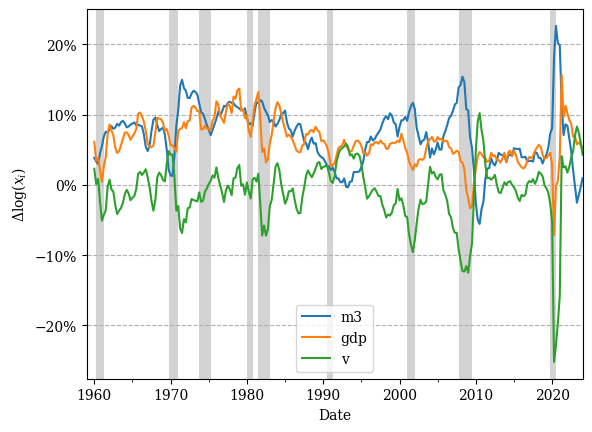

In [13]:
df_deltaLog = df_us[['m3', 'gdp', 'v']].apply(np.log).diff(periods=4)
df_deltaLog['recession'] = df_us['recession']

fig, ax = plt.subplots()
df_deltaLog[['m3', 'gdp', 'v']].plot(ax=ax)
plot_recessions(ax)

ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.grid(which='major', axis='y', linestyle='--')  #  or both
ax.set_ylabel(r'$\Delta\log(x_i)$');

In [124]:
from scipy.stats import t

mu_0 = 0
mean_yi = df_deltaLog['v'].mean()
sm_yi = df_deltaLog['v'].std()
T = df_deltaLog['v'].count()  #  Excluye valores N/A
sm_medias = sm_yi / np.sqrt(T)

t_score = (mean_yi - mu_0) / sm_medias
p_value = 2*t.sf(np.abs(t_score), T-1)
print(f'p-value: {p_value:.5f}')
# Se rechaza H0: mu0=0 al 99%

print(f'mu = {mean_yi*100:.2f}%')
print(
    f"mu = {df_deltaLog.loc[:'2019-12-31', 'v'].mean()*100:.2f}% (hasta 2019.IV)")

print(f'std = {sm_yi*100:.2f}%')
print(
    f"std = {df_deltaLog.loc[:'2019-12-31', 'v'].std()*100:.2f}% (hasta 2019.IV)")

p-value: 0.00174
mu = -0.88%
mu = -0.81% (hasta 2019.IV)
std = 4.48%
std = 3.58% (hasta 2019.IV)


In [125]:
# %% Augmented Dickey-Fuller
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_deltaLog['v'].dropna(), regression='c', autolag='AIC')
print('Augmented Dickey-Fuller')
print(f'\tADF statistic: {result[0]}')
print(f'\tp-value: {result[1]}')
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

Augmented Dickey-Fuller
	ADF statistic: -3.049072640460463
	p-value: 0.030558879520383154
Critical Values:
	1%: -3.458
	5%: -2.874
	10%: -2.573


### Autorregresión de Markov

$\Delta\log v_t = \mu s_t + \beta d_\text{recession} + \varepsilon_t$

$\varepsilon_t \sim N(0, \sigma^2)$

$S_t\in \{0,1\}$

$P(S_t=s_t|S_{t-1}=s_{t-1})=
\begin{bmatrix}
  p_{00} & p_{10}\\
  1-p_{00} & 1-p_{10}
\end{bmatrix}$

Referencias:
- Reference: https://stackoverflow.com/questions/42796743/python-statsmodel-tsa-markovautoregression-using-current-real-gnp-gdp-data
- Reference: https://nbviewer.org/gist/ChadFulton/a5d24d32ba3b7b2e381e43a232342f1f
- statsmodels: https://www.statsmodels.org/dev/generated/statsmodels.tsa.regime_switching.markov_autoregression.MarkovAutoregression.html
- statsmodels: https://www.statsmodels.org/dev/examples/notebooks/generated/markov_regression.html
- mswitch (Stata): https://www.stata.com/manuals14/tsmswitch.pdf


Estimated duration: [80.77844366  6.10272022]


/Users/miguel/Documents/workspace/money-growth/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                      v   No. Observations:                  257
Model:               MarkovRegression   Log Likelihood                 496.370
Date:                Sun, 08 Sep 2024   AIC                           -980.740
Time:                        13:16:15   BIC                           -959.445
Sample:                    01-01-1960   HQIC                          -972.176
                         - 01-01-2024                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.002      0.654      0.513      -0.003       0.006
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1086      0.011     -9.562      0.000      -0.131      -0.086
                           Non-switching parameters                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0149      0.007     -2.238      0.025      -0.028      -0.002
sigma2         0.0011   9.67e-05     10.942      0.000       0.001       0.001
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9876      0.007    132.274      0.000       0.973       1.002
p[1->0]        0.1639      0.087      1.887      0.059      -0.006       0.334
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

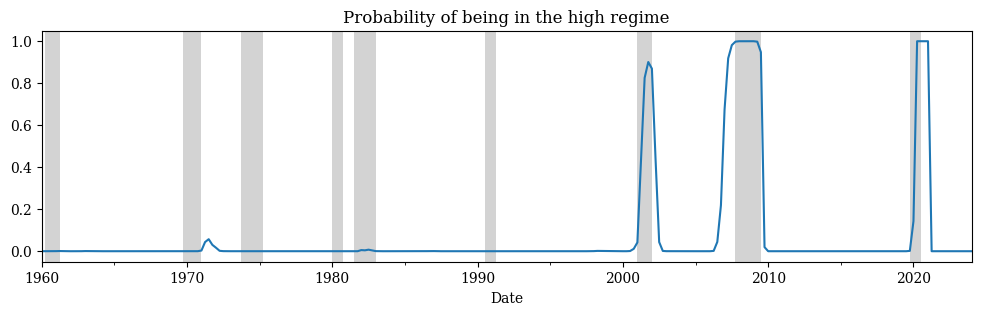

In [26]:
import statsmodels.api as sm

y = df_deltaLog.dropna()['v'].astype(float)
X = df_deltaLog.dropna()['recession'].astype(float)
# X = sm.add_constant(X)

model = sm.tsa.MarkovRegression(
    y, k_regimes=2,
    exog=X,  
    switching_exog=False,
    trend='c'
)
res = model.fit()


fig, ax = plt.subplots(figsize=(12, 3))

res.smoothed_marginal_probabilities[1].plot(
    title="Probability of being in the high regime", ax=ax
)
plot_recessions(ax)

print(f'Estimated duration: {res.expected_durations}')
res.summary()

## Eurozona

Datos: 
- GDP: Gross domestic product at market prices, Euro area 20 (fixed composition) as of 1 January 2023, Quarterly. [ECB](https://data.ecb.europa.eu/data/datasets/MNA/MNA.Q.Y.I9.W2.S1.S1.B.B1GQ._Z._Z._Z.EUR.LR.N)
- M3: Monetary aggregate M3 reported by MFIs, central gov. and post office giro institutions in the euro area (stocks), Euro area (changing composition), Monthly. [ECB](https://data.ecb.europa.eu/data/datasets/BSI/BSI.M.U2.N.V.M30.X.1.U2.2300.Z01.E).

In [38]:
from importlib import reload
# import utils
# reload(utils)
from utils import get_snb_data, get_ecb_data


df_eu = pd.DataFrame()
df_eu['gdp'] = get_ecb_data('MNA',
                      'Q.Y.I9.W2.S1.S1.B.B1GQ._Z._Z._Z.EUR.LR.N', date_format='%Y-Q%q').rename(columns={'OBS_VALUE': 'gdp'})

df_eu['m3'] = get_ecb_data('BSI',
                     'Q.U2.N.V.M30.X.1.U2.2300.Z01.E', date_format='%Y-Q%q').rename(columns={'OBS_VALUE': 'm3'})
df_eu.dropna(inplace=True) # Remove NaN
df_eu['v'] = df_eu['gdp']/df_eu['m3']

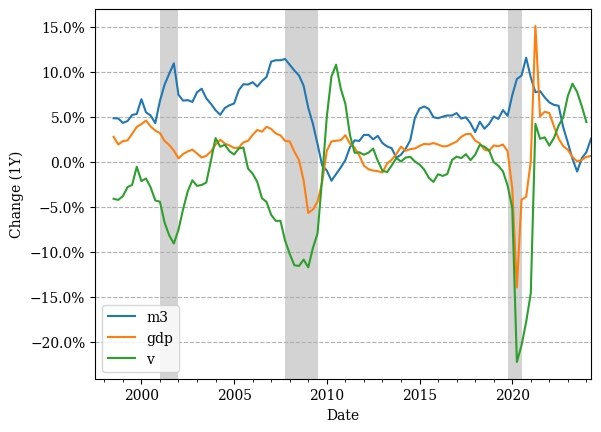

In [149]:
fig, ax = plt.subplots()

df_eu[['m3', 'gdp', 'v']].pct_change(periods=4, fill_method=None).plot(ax=ax)
plot_recessions(ax)

ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.grid(which='major', axis='y', linestyle='--')  #  or both
ax.set_ylabel('Change (1Y)');